# Deep Reinforcement Learning using AlphaZero methodology

Please see https://applied-data.science/blog/how-to-build-your-own-alphazero-ai-using-python-and-keras/ for further notes on the codebase

## 1. First load the core libraries

In [1]:
# -*- coding: utf-8 -*-
# %matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
np.set_printoptions(suppress=True)

from shutil import copyfile
import random
from importlib import reload


from keras.utils import plot_model

from game import Game, GameState
from agent import Agent
from memory import Memory
from model import Residual_CNN
from funcs import playMatches, playMatchesBetweenVersions

import loggers as lg

from settings import run_folder, run_archive_folder
import initialise
import pickle

Using TensorFlow backend.


## 2. Now run this block to start the learning process

This block loops for ever, continually learning from new game data.

The current best model and memories are saved in the run folder so you can kill the process and restart from the last checkpoint.

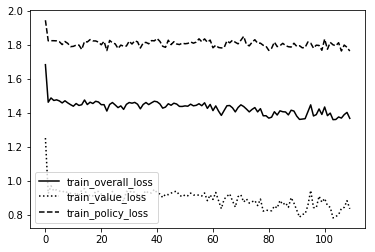




TOURNAMENT...
1 2 3 4 5 6 7 8 9 10 11 12 13 

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [2]:
lg.logger_main.info('=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*')
lg.logger_main.info('=*=*=*=*=*=.      NEW LOG      =*=*=*=*=*')
lg.logger_main.info('=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*')

env = Game()

# If loading an existing neural network, copy the config file to root
if initialise.INITIAL_RUN_NUMBER != None:
    copyfile(run_archive_folder + env.name + '/run' + str(initialise.INITIAL_RUN_NUMBER).zfill(4) + '/config.py', './config.py')

import config

######## LOAD MEMORIES IF NECESSARY ########

if initialise.INITIAL_MEMORY_VERSION == None:
    memory = Memory(config.MEMORY_SIZE)
else:
    print('LOADING MEMORY VERSION ' + str(initialise.INITIAL_MEMORY_VERSION) + '...')
    memory = pickle.load( open( run_archive_folder + env.name + '/run' + str(initialise.INITIAL_RUN_NUMBER).zfill(4) + "/memory/memory" + str(initialise.INITIAL_MEMORY_VERSION).zfill(4) + ".p",   "rb" ) )

######## LOAD MODEL IF NECESSARY ########

# create an untrained neural network objects from the config file
current_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) + env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)
best_NN = Residual_CNN(config.REG_CONST, config.LEARNING_RATE, (2,) +  env.grid_shape,   env.action_size, config.HIDDEN_CNN_LAYERS)

#If loading an existing neural netwrok, set the weights from that model
if initialise.INITIAL_MODEL_VERSION != None:
    best_player_version  = initialise.INITIAL_MODEL_VERSION
    print('LOADING MODEL VERSION ' + str(initialise.INITIAL_MODEL_VERSION) + '...')
    m_tmp = best_NN.read(env.name, initialise.INITIAL_RUN_NUMBER, best_player_version)
    current_NN.model.set_weights(m_tmp.get_weights())
    best_NN.model.set_weights(m_tmp.get_weights())
#otherwise just ensure the weights on the two players are the same
else:
    best_player_version = 0
    best_NN.model.set_weights(current_NN.model.get_weights())

#copy the config file to the run folder
copyfile('./config.py', run_folder + 'config.py')
plot_model(current_NN.model, to_file=run_folder + 'models/model.png', show_shapes = True)

print('\n')

######## CREATE THE PLAYERS ########

current_player = Agent('current_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, current_NN)
best_player = Agent('best_player', env.state_size, env.action_size, config.MCTS_SIMS, config.CPUCT, best_NN)
#user_player = User('player1', env.state_size, env.action_size)
iteration = 0

while 1:

    iteration += 1
    reload(lg)
    reload(config)
    
    print('ITERATION NUMBER ' + str(iteration))
    
    lg.logger_main.info('BEST PLAYER VERSION: %d', best_player_version)
    print('BEST PLAYER VERSION ' + str(best_player_version))

    ######## SELF PLAY ########
    print('SELF PLAYING ' + str(config.EPISODES) + ' EPISODES...')
    _, memory, _, _ = playMatches(best_player, best_player, config.EPISODES, lg.logger_main, turns_until_tau0 = config.TURNS_UNTIL_TAU0, memory = memory)
    print('\n')
    
    memory.clear_stmemory()
    
    if len(memory.ltmemory) >= config.MEMORY_SIZE:

        ######## RETRAINING ########
        print('RETRAINING...')
        current_player.replay(memory.ltmemory)
        print('')

        if iteration % 5 == 0:
            pickle.dump( memory, open( run_folder + "memory/memory" + str(iteration).zfill(4) + ".p", "wb" ) )

        lg.logger_memory.info('====================')
        lg.logger_memory.info('NEW MEMORIES')
        lg.logger_memory.info('====================')
        
        memory_samp = random.sample(memory.ltmemory, min(1000, len(memory.ltmemory)))
        
        for s in memory_samp:
            current_value, current_probs, _ = current_player.get_preds(s['state'])
            best_value, best_probs, _ = best_player.get_preds(s['state'])

            lg.logger_memory.info('MCTS VALUE FOR %s: %f', s['playerTurn'], s['value'])
            lg.logger_memory.info('CUR PRED VALUE FOR %s: %f', s['playerTurn'], current_value)
            lg.logger_memory.info('BES PRED VALUE FOR %s: %f', s['playerTurn'], best_value)
            lg.logger_memory.info('THE MCTS ACTION VALUES: %s', ['%.2f' % elem for elem in s['AV']]  )
            lg.logger_memory.info('CUR PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  current_probs])
            lg.logger_memory.info('BES PRED ACTION VALUES: %s', ['%.2f' % elem for elem in  best_probs])
            lg.logger_memory.info('ID: %s', s['state'].id)
            lg.logger_memory.info('INPUT TO MODEL: %s', current_player.model.convertToModelInput(s['state']))

            s['state'].render(lg.logger_memory)
            
        ######## TOURNAMENT ########
        print('TOURNAMENT...')
        scores, _, points, sp_scores = playMatches(best_player, current_player, config.EVAL_EPISODES, lg.logger_tourney, turns_until_tau0 = 0, memory = None)
        print('\nSCORES')
        print(scores)
        print('\nSTARTING PLAYER / NON-STARTING PLAYER SCORES')
        print(sp_scores)
        #print(points)

        print('\n\n')

        if scores['current_player'] > scores['best_player'] * config.SCORING_THRESHOLD:
            best_player_version = best_player_version + 1
            best_NN.model.set_weights(current_NN.model.get_weights())
            best_NN.write(env.name, best_player_version)

    else:
        print('MEMORY SIZE: ' + str(len(memory.ltmemory)))

## The following panels are not involved in the learning process

### Play matches between versions (use -1 for human player)

In [ ]:
from game import Game
from funcs import playMatchesBetweenVersions
import loggers as lg

env = Game()
playMatchesBetweenVersions(env, 1, 1, 1, 10, lg.logger_tourney, 0)

### Pass a particular game state through the neural network (setup below for Connect4)

In [ ]:
gs = GameState(np.array([
    0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,
    0,0,0,0,0,0,0,
    0,0,0,0,0,0,0
]), 1)

preds = current_player.get_preds(gs)

print(preds)

### See the layers of the current neural network

In [ ]:
current_player.model.viewLayers()

### Output a diagram of the neural network architecture

In [ ]:
from keras.utils import plot_model
plot_model(current_NN.model, to_file=run_folder + 'models/model.png', show_shapes = True)